In [1]:
import os
import urllib.request

output_dir = "../../LCMS/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/LCMS/SUB13853/1338.SUB13853_MetabolomicsData.xlsx']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!


In [337]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text


In [87]:
# Load data 

# Load the Excel file
excel_file = os.path.join(output_dir, '1338.SUB13853_MetabolomicsData.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'Untargeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)
metadata = pd.read_excel(excel_file, sheet_name='SamplesNames')
metadata = metadata.iloc[4:16]

dictionary = dict(zip(metadata['Unnamed: 1'], metadata['Unnamed: 4']))

/Users/djuna/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [113]:
metadata

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
4,F3,SUB13853p4_SPL01,1A,1,Control,NaN,395200,22,NaN,NaN,NaN
5,F4,SUB13853p4_SPL02,2B,1,Control,NaN,395200,22,NaN,NaN,NaN
6,F5,SUB13853p4_SPL03,3C,1,Control,NaN,395200,22,NaN,NaN,NaN
7,F6,SUB13853p4_SPL04,4D,1,ABCA7 LoF,NaN,424000,23.603239,NaN,NaN,NaN
8,F7,SUB13853p4_SPL05,5E,1,ABCA7 LoF,NaN,434000,24.159919,NaN,NaN,NaN
9,F8,SUB13853p4_SPL06,6F,1,ABCA7 LoF,NaN,444000,24.716599,NaN,NaN,NaN
10,F9,SUB13853p4_SPL07,7G,2,Control,H2O,395200,22,NaN,NaN,NaN
11,F10,SUB13853p4_SPL08,8H,2,Control,H2O,395200,22,NaN,NaN,NaN
12,F11,SUB13853p4_SPL09,9I,2,Control,H2O,395200,22,NaN,NaN,NaN
13,F12,SUB13853p4_SPL10,10J,2,ABCA7 LoF,H2O,395200,22,NaN,NaN,NaN


In [226]:
pd.DataFrame(data.iloc[6:,[1,2]])

,Unnamed: 1,Unnamed: 2
6,Name,Tags
7,"β,β-Dimethyl-γ-methylene-γ-butyrolactone",Weak/poor match;Background Cpd
8,Xylenesulfonate,Weak/poor match;Background Cpd
9,Valeric acid,Level 2 ID;Background Cpd
10,Uridine,MasslistRT ID
...,...,...
402,NaN,NaN
403,NaN,NaN
404,NaN,NaN
405,NaN,NaN


In [227]:
# get the normalized areas
norm_areas = data.iloc[6:,48:-3]
norm_areas.columns = [x.split(' ')[2].split('.')[0] for x in norm_areas.iloc[0]]
norm_areas = norm_areas[1:]
norm_areas.index = np.arange(len(norm_areas))
norm_areas_subset = norm_areas.loc[:,dictionary.keys()]

# get background compounts info
tags = pd.DataFrame(data.iloc[6:,[1,2]])
tags.columns = ['Name','Tag']
tags = tags[1:]
tags.index = np.arange(len(tags))
tags['is_background'] = [True if 'Background' in str(x) else False for x in tags['Tag'].values]
tags['Level_1'] = [True if 'Level 1' in str(x) else False for x in tags['Tag'].values]
tags['Level_2'] = [True if 'Level 2' in str(x) else False for x in tags['Tag'].values]

# subset the data to remove background compounds
norm_areas_subset_no_background = norm_areas_subset[np.invert(tags['is_background'])]

In [228]:
# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(norm_areas_subset_no_background.T)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_components['condition'] = [dictionary[x] for x in norm_areas_subset_no_background.columns.values]

166.14585903434818
145.0263513594557


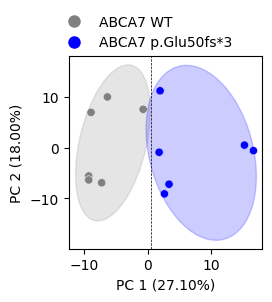

In [229]:
# plot the data
plt.figure(figsize=(2.5, 2.5))
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette={'Control': 'grey', 'ABCA7 LoF': 'blue'}, edgecolor='w')

for treatment in principal_components['condition'].unique():
    line_data = principal_components[principal_components['condition'] == treatment]
    confidence_ellipse = np.cov(line_data['PC1'], line_data['PC2'])
    eigenvals, eigenvecs = np.linalg.eig(confidence_ellipse)
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    print(angle)
    if treatment == 'Control':
        angle = 170
        ellipse = patches.Ellipse(xy=(line_data['PC1'].mean()+1.5, line_data['PC2'].mean()),
                                width=1.95*np.sqrt(eigenvals[0])*2,
                                height=1.9*np.sqrt(eigenvals[1])*2,
                                angle=angle,
                                fill=True,
                                alpha=0.2,
                                color='blue' if treatment=='ABCA7 LoF' else 'grey')
    else:
        angle = 190
        ellipse = patches.Ellipse(xy=(line_data['PC1'].mean()+1.5, line_data['PC2'].mean()),
                                width=1.2*np.sqrt(eigenvals[0])*2,
                                height=2.4*np.sqrt(eigenvals[1])*2,
                                angle=angle,
                                fill=True,
                                alpha=0.2,
                                color='blue' if treatment=='ABCA7 LoF' else 'grey')
    plt.gca().add_patch(ellipse)

explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Glu50fs*3')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)
# plt.xlim(-13,10)
# plt.ylim(-11,13)
plt.savefig('../../paper/main_plots/metabolomics_pca.png', dpi=300, bbox_inches='tight')
plt.show()

In [260]:
index = np.invert(tags['is_background'])
tags_no_background = tags[index]
names = np.array([dictionary[x] for x in norm_areas_subset_no_background.columns.values])

all_pvalues = []
all_logfc = []
for i in range(norm_areas_subset_no_background.shape[0]):
    current_row = norm_areas_subset_no_background.iloc[i]
    control_values = current_row[names=='Control'].values
    lof_values = current_row[names=='ABCA7 LoF'].values
    t_stat, p_value = ttest_ind(control_values.astype(float), lof_values.astype(float), equal_var=True, alternative='two-sided')
    logfc = np.log2(np.mean(lof_values)/np.mean(control_values))
    all_pvalues.append(p_value)
    all_logfc.append(logfc)


In [264]:
tags_no_background['p_value'] = all_pvalues
tags_no_background['log2_fold_change'] = all_logfc

_, fdr_corrected_pvals, _, _ = smm.multipletests(tags_no_background['p_value'], alpha=0.05, method='fdr_bh')
tags_no_background['FDR'] = fdr_corrected_pvals

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/2393976097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_no_background['p_value'] = all_pvalues
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/2393976097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_no_background['log2_fold_change'] = all_logfc
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/2393976097.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [324]:
tags_no_background['names_show'] = tags_no_background['Name'].copy().astype(str)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/2425312949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_no_background['names_show'] = tags_no_background['Name'].copy().astype(str)


In [302]:
tags_no_background

,Name,Tag,is_background,Level_1,Level_2,p_value,log2_fold_change,FDR,names_show
3,Uridine,MasslistRT ID,False,False,False,0.668977,-0.328265,0.816746,Uridine
10,Sucrose or other disaccharide,Weak/poor match,False,False,False,0.284423,0.855940,0.586345,Sucrose or other disaccharide
13,Similar to NP-021868,Other ID,False,False,False,0.328335,0.287250,0.586345,Similar to NP-021868
21,Similar to Carnosine,Weak/poor match;Other ID,False,False,False,0.003116,-0.778706,0.024619,Similar to Carnosine
29,Propionylcarnitine,Level 2 ID,False,False,True,0.000004,-3.545656,0.000819,Propionylcarnitine
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,False,False,False,0.027513,1.506806,0.131772,nan
396,NaN,NaN,False,False,False,0.166291,0.800187,0.480525,nan
397,NaN,NaN,False,False,False,0.240539,1.171766,0.567631,nan
398,NaN,NaN,False,False,False,0.936540,0.082894,0.958726,nan


In [325]:
tags_no_background['names_show'][tags_no_background['FDR']>0.05] = ''
tags_no_background['names_show'][tags_no_background['Tag']=='Weak/poor match'] = ''
tags_no_background['names_show'][tags_no_background['Tag']=='Weak/poor match;Other ID'] = ''
tags_no_background['names_show'][tags_no_background['Tag']=='FISHhit'] = ''
tags_no_background['names_show'][tags_no_background['names_show']=='nan'] = ''



/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/2514871398.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tags_no_background['names_show'][tags_no_background['FDR']>0.05] = ''
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw000

In [319]:
tags_no_background['names_show'][222]

''

In [334]:
tags_no_background[tags_no_background['names_show']==gene]['cat'].values[0]

'down'

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/3783692431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_no_background['size'] = np.where(tags_no_background['names_show']!='', 50, 10)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/3783692431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_no_background['cat'] = ''
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_65017/3783692431.py:6: FutureWarning: ChainedAssignmentError: behaviour will chang

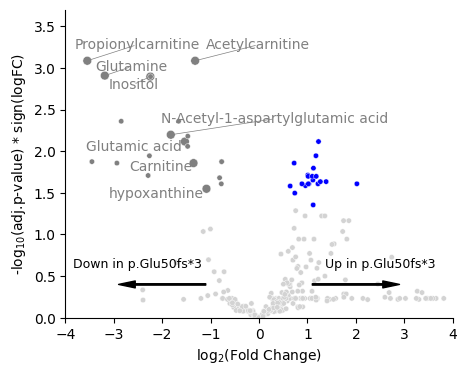

In [397]:
# Your scatterplot
plt.figure(figsize=(5, 4))

tags_no_background['size'] = np.where(tags_no_background['names_show']!='', 50, 10)
tags_no_background['cat'] = ''
tags_no_background['cat'][(tags_no_background['log2_fold_change']<0) & (tags_no_background['FDR']<0.05)] = 'down'
tags_no_background['cat'][(tags_no_background['log2_fold_change']>0) & (tags_no_background['FDR']<0.05)] = 'up'
tags_no_background['cat'][tags_no_background['FDR']>0.05] = 'other'
palette = {'down': 'grey', 'up': 'blue', 'other': 'lightgrey'}
sns.scatterplot(data=tags_no_background, x='log2_fold_change', y=-1*np.log10(tags_no_background['FDR']), hue='cat', size='size', sizes=(15, 40), palette=palette)
# Label top genes

top_genes = tags_no_background[tags_no_background['names_show']!='']['Name'].values

texts = []
for gene in top_genes:
        color = palette[tags_no_background[tags_no_background['names_show']==gene]['cat'].values[0]]
        txt = plt.text(tags_no_background[tags_no_background['names_show']==gene]['log2_fold_change'].values[0],
                       -1 * np.log10(tags_no_background[tags_no_background['names_show']==gene]['FDR'].values[0]),
                       gene, fontsize=10, ha='right', va='bottom', color='grey')
        texts.append(txt)

# Adjust text positions to reduce overlap
plt.xlim(-4, 4)
plt.ylim(0,3.7)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=.5), expand_text=(1.2, 2),  # Increase the expansion factor for text labels
    expand_points=(1.2, 1.2),  # Increase the expansion factor for points
    force_text=10,  # Adjust these force values as needed
    force_points=0.5)

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(3,0.4), xytext=(1, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2.5, .6, 'Up in p.Glu50fs*3', ha='center', fontsize=9)

plt.annotate('', xy=(-3,0.4), xytext=(-1, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2.5, .6, 'Down in p.Glu50fs*3', ha='center', fontsize=9)
plt.legend().remove()
plt.title('', fontsize=11)

plt.savefig('../../paper/main_plots/metabolomics_volcano.png', dpi=300, bbox_inches='tight')

plt.show()


In [420]:
from statannotations.Annotator import Annotator

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, ylim):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.4, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )

    ax.set_ylim(0,ylim)
    ax.set_xlim(-0.5, len(order)+5)
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.05, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                        verbose=2, show_test_name=False, line_offset_to_group=1,  # Increases space between the brackets and the plot
    text_offset=4, line_width=1)
    annotator.apply_and_annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax


#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


In [413]:
i

4

In [402]:
norm_areas_subset_no_background

,SUB13853p4_SPL01,SUB13853p4_SPL02,SUB13853p4_SPL03,SUB13853p4_SPL04,SUB13853p4_SPL05,SUB13853p4_SPL06,SUB13853p4_SPL07,SUB13853p4_SPL08,SUB13853p4_SPL09,SUB13853p4_SPL10,SUB13853p4_SPL11,SUB13853p4_SPL12
3,158849.73062,169262.877212,145744.960747,176373.267514,227978.532313,420508.164616,138033.583975,213549.110299,938304.098286,260780.083642,130075.500491,189096.344162
10,90418.26018,123027.525759,135636.084646,82348.270922,140994.813079,114120.53368,26644.625447,21227.748567,254380.642414,194354.877652,534757.113636,112300.173815
13,15574779.643278,15826318.280714,12335365.138369,21303252.899611,18804921.641035,16331259.482717,10537204.760986,7419647.783605,9269083.588237,7868244.656358,11529580.55975,10758977.414131
21,40007117.913713,30672411.912348,30666470.124877,16065136.011474,15243665.551654,28944642.086783,28539503.151657,22833601.355133,38795677.329992,19324671.890931,17902766.231014,14151075.998131
29,5592370.086051,4762824.308846,6592255.420018,180632.130206,440729.541905,877965.011581,7583456.503054,3931904.83707,4878641.647523,756282.859045,249095.592875,350489.363466
...,...,...,...,...,...,...,...,...,...,...,...,...
395,28783.013278,49641.570096,44709.783789,98273.769142,60507.367711,73887.359875,24140.698973,27627.723748,43625.940212,40460.161466,134701.259734,213185.445711
396,40281.62901,59618.425432,26828.164914,38267.534002,34270.07414,24110.222281,17068.930987,9508.761454,20363.874418,28373.225008,91258.617341,86136.082843
397,69744.023423,72067.575278,62927.569263,80081.328659,71289.863511,81476.27927,73629.900069,185828.425985,301656.367561,169353.345834,562821.823672,760348.268256
398,275724.040352,15525391.781731,777492.062678,14557766.713045,2328536.936682,15798909.163894,13559697.111799,1361528.13219,2314776.844853,1928378.403106,352590.258509,848239.420952


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

Control vs. ABCA7 LoF: t-test independent samples, P_val:3.665e-06 t=9.122e+00
Control vs. ABCA7 LoF: t-test independent samples, P_val:5.996e-06 t=8.635e+00
Control vs. ABCA7 LoF: t-test independent samples, P_val:1.014e-03 t=4.578e+00


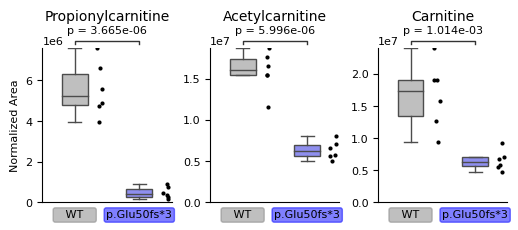

In [455]:
fig = plt.figure(figsize=(6, 2))
gs = fig.add_gridspec(1, 3, width_ratios=[1,1, 1])  # adjust ratios as needed

order = ['Control', 'ABCA7 LoF']
pairs = [(('Control'), ('ABCA7 LoF'))]
palette=['grey', 'blue']

# First plot
i = np.where(tags_no_background['Name']=='Propionylcarnitine')[0][0]
norm_areas_subset_no_background.index = np.arange(len(norm_areas_subset_no_background))
df = pd.DataFrame(norm_areas_subset_no_background.iloc[i])
df['condition'] = [dictionary[x] for x in df.index.values]
df.columns = ['Propionylcarnitine', 'condition']
df['Propionylcarnitine'] = df['Propionylcarnitine'].astype(float)

ax1 = fig.add_subplot(gs[0])
plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(df, 'condition', 'Propionylcarnitine', order = order, pairs = pairs,palette=palette, 
                                ylim = np.max(df['Propionylcarnitine']) )
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Normalized Area', fontsize=8)
ax1.set_title('Propionylcarnitine', fontsize=10, pad=20)
ax1.text(0, -0.05, "   WT   ", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)

ax1.text(1, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=8)

# second plot
i = np.where(tags_no_background['Name']=='Acetylcarnitine')[0][0]
norm_areas_subset_no_background.index = np.arange(len(norm_areas_subset_no_background))
df = pd.DataFrame(norm_areas_subset_no_background.iloc[i])
df['condition'] = [dictionary[x] for x in df.index.values]
df.columns = ['Acetylcarnitine', 'condition']
df['Acetylcarnitine'] = df['Acetylcarnitine'].astype(float)

ax2 = fig.add_subplot(gs[1])
plt.sca(ax2)

ax2 = plot_boxplot_by_treatment(df, 'condition', 'Acetylcarnitine', order = order, pairs = pairs,palette=palette, 
                                ylim = np.max(df['Acetylcarnitine']) )
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Acetylcarnitine', fontsize=10, pad=20)
ax2.text(0, -0.05, "   WT   ", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)

ax2.text(1, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=8)

ax2.set_ylabel('', fontsize=8)

# third plot
i = np.where(tags_no_background['Name']=='Carnitine')[0][0]
norm_areas_subset_no_background.index = np.arange(len(norm_areas_subset_no_background))
df = pd.DataFrame(norm_areas_subset_no_background.iloc[i])
df['condition'] = [dictionary[x] for x in df.index.values]
df.columns = ['Carnitine', 'condition']
df['Carnitine'] = df['Carnitine'].astype(float)

ax3 = fig.add_subplot(gs[2])
plt.sca(ax3)

ax3 = plot_boxplot_by_treatment(df, 'condition', 'Carnitine', order = order, pairs = pairs,palette=palette, 
                                ylim = np.max(df['Carnitine']) )
ax3.set_xticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_title('Carnitine', fontsize=10, pad=20)
ax3.set_ylabel('', fontsize=8)
ax3.text(0, -0.05, "   WT   ", ha='center', va='top', transform=ax3.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)

ax3.text(1, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax3.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=8)

plt.subplots_adjust(wspace=0.3)

plt.savefig('../../paper/main_plots/metab_species.png', dpi=300, bbox_inches='tight')